In [25]:
import cv2
import numpy
import os
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.io import imread, imshow

In [8]:
df = pd.DataFrame()
datasetPath = Path('seg_train')
patharr = [ os.path.join(datasetPath, f) for f in os.listdir(datasetPath) if os.path.isdir(os.path.join(datasetPath, f))]
for dirpath in patharr:
    category = dirpath.split("\\")[1]
    df1 = pd.DataFrame()
    df1['image'] = [ os.path.join(dirpath, f) for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f))]
    df1['imgcategory'] = [ category for i in range(0, len(df1['image']))]
    df = df.append(df1)
    del df1
df.head()

,image,imgcategory
0,seg_train\buildings\0.jpg,buildings
1,seg_train\buildings\10006.jpg,buildings
2,seg_train\buildings\1001.jpg,buildings
3,seg_train\buildings\10014.jpg,buildings
4,seg_train\buildings\10018.jpg,buildings


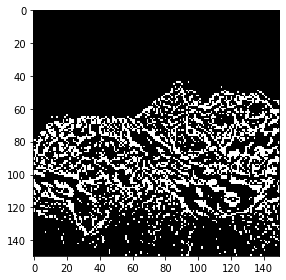

In [163]:
img = imread("seg_train/mountain/1151.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,14)
imshow(img_gray)

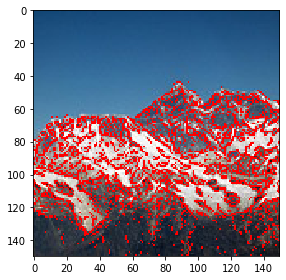

In [164]:
contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (255,0,0), 0)
imshow(img)

In [153]:
def findDescriptor(img):
    """ findDescriptor(img) finds and returns the
    Fourier-Descriptor of the image contour"""
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,14)
    contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_vector = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        for point in contour:
            # -x and -y are to make left and upper boundry start from 0
            contour_vector.append(complex(point[0][0] - x, (point[0][1] - y)))

    if(len(contour_vector) == 0):
        return numpy.array(contour_vector)
    FD = numpy.fft.fft(contour_vector)
    firstVal = FD[0]
    for index, value in enumerate(FD):
        FD[index] = numpy.absolute(value)/firstVal
    FD = FD[1:len(FD)]
    FD = FD[:56]
    return FD

In [154]:
data_features = numpy.empty([len(df['image']), 26], complex)
for i in range(0, len(df['image'])):
    data_features[index] = imgfeatures[index][:26]
imgfeatures = data_features   

In [155]:
def getimagefeatures():
    database_features = numpy.empty([len(df['image']), 56], complex)
    index = 0
    for imgpath in df['image']:
        image = cv2.imread(imgpath)
        image_features = findDescriptor(image)
        if(len(image_features)>=56): 
            database_features[index] = image_features
        else:
            database_features[index] = 1000 * numpy.random.random_sample((56,))
        index += 1
        if(index%1000 == 0):
            print(index);
    return database_features

imgfeatures = getimagefeatures();

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [171]:
numimages = 29
def match_image(randomimage, image_cat, mode='noshow'):
    if(mode=='show'):
        axes=[]
        fig=plt.figure(figsize=(8,8))
    query_features = findDescriptor(randomimage)
    distancevector = numpy.empty([len(df['image'])])
    for i in range(0, len(df['image'])):
        image_features = imgfeatures[i]
        distancevector[i] = numpy.linalg.norm(image_features - query_features, axis=0)
    indexes = numpy.arange(distancevector.shape[0])
    dis_frame = pd.DataFrame({'Distance': distancevector, 'Index': indexes})
    dis_frame = dis_frame.reset_index(drop=True)
    dis_frame = dis_frame.sort_values('Distance', ascending=True)
    index = 0
    correct = 0
    for item in dis_frame.itertuples(index=True, name='Pandas'):
        if(index >= numimages):
            break
        img_index = item.Index
        if(df.iloc[img_index].imgcategory == image_cat):
            correct += 1
        if(index < 18 and mode=='show'):
            image = imread(df.iloc[item.Index].image)
            axes.append(fig.add_subplot(5, 6, index+1))
            plt.axis('off')
            plt.imshow(image)
        index+=1
    print('Accuracy with hsv_histogram and euclidian distance - ', (correct/numimages)*100, '%')
    if(mode=='show'):
        fig.tight_layout()
        plt.show()
    return (correct/numimages)*100

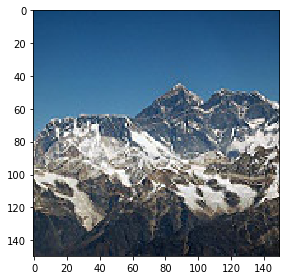

In [172]:
image_name = 'seg_train\\mountain\\1151.jpg'
image_cat = 'mountain'
img = imread(image_name)
imshow(img)

Accuracy with hsv_histogram and euclidian distance -  48.275862068965516 %


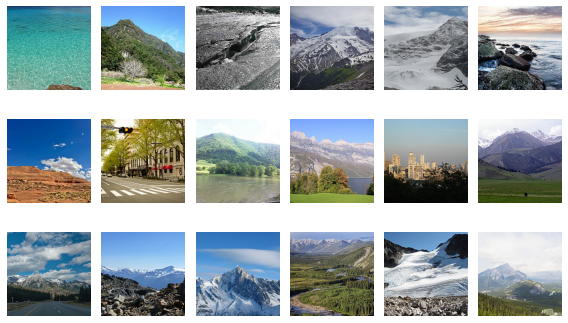

48.275862068965516

In [173]:

match_image(img, image_cat, mode='show')